### paper plots

pretty plots for final paper

In [10]:
!jt -t oceans16 -fs 10 -cellw 93% -nfs 10 -lineh 120 -tfs 10 -dfs 8 -ofs 8 -mathfs 100

In [20]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.evaluate as ev
import glob
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import glob
import os
import tensorflow as tf

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

reload(ev)
reload(utils)

<module 'autoencodeSVJ.utils' from '/afs/cern.ch/user/l/llepotti/.local/lib/python2.7/site-packages/autoencodeSVJ/utils.pyc'>

In [21]:
# ev.update_all_signal_evals()
# ev.get_training_info_dict('training_name')
# ev.check_training('training_name')
# utils.load_summary(utils.summary_by_name('hlf_eflow3_8_v36'))

In [22]:
aucs = ev.load_auc_table()
aucs_old = ev.load_auc_table('TEST')
bdts = pd.read_csv('autoencode/data/bdt_aucs.csv')
bdts = bdts[bdts.columns[1:]].set_index(bdts[bdts.columns[0]].rename('mass'))
bdts = bdts.T.set_index(bdts.T.index.rename('nu')).T
bdts.columns = map(float, bdts.columns)
bdts.index = map(float, bdts.index)

In [23]:
def get_signal_auc_df(aucs, n_avg=1, do_max=False):
    lp = None
    if do_max:
        lp = aucs.max(axis=1).to_frame().reset_index().rename(columns={0:'auc'})
    else:
        lp = aucs.iloc[
            :,np.argsort(aucs.mean()).values[::-1][:n_avg]
        ].mean(axis=1).to_frame().reset_index().rename(columns={0: 'auc'})

    lp['mass'] = lp.mass_nu_ratio.apply(lambda x: x[0])
    lp['nu'] = lp.mass_nu_ratio.apply(lambda x: x[1])
    
    lp = lp.drop('mass_nu_ratio', axis=1).pivot('mass','nu',  'auc')

    return lp
                                                
def plot_signal_aucs_from_lp(lp, n_avg=1, do_max=False, title=None, fac=1.5, barlabel=None, cmap='viridis'):

    plt.figure(figsize=(1.1*fac*6.9,1.1*fac*6))

    plt.imshow(lp, cmap=cmap)
    if barlabel == None:
        barlabel='AUC value'
    cb = plt.colorbar()
    cb.set_label(label=barlabel, fontsize=18*fac)

    plt.xticks(np.arange(0,5,1), map(lambda x: '{:.2f}'.format(x), np.unique(lp.columns)))
    plt.yticks(np.arange(0,6,1), np.unique(lp.index))
    
    if title is not None:
        plt.title(title, fontsize=fac*25)
    elif do_max:
        plt.title('Best AUCs (for any autoencoder)', fontsize=fac*25)
    elif n_avg < 2:
        plt.title('Signal AUCs (best autoencoder)', fontsize=fac*25)
    else:
        plt.title('Average Signal AUCs (best {} models)'.format(n_avg), fontsize=fac*25)
    plt.ylabel(r'$M_{Z^\prime}$ (GeV)', fontsize=fac*20)
    plt.xlabel(r'$r_{inv}$', fontsize=fac*20)
    plt.xticks(fontsize=18*fac)
    plt.yticks(fontsize=18*fac)

    for mi,(mass,row) in enumerate(lp.iterrows()):
        for ni,(nu,auc) in enumerate(row.iteritems()):
            plt.text(ni, mi, '{:.3f}'.format(auc), ha="center", va="center", color="w", fontsize=18*fac)

    return plt.gca()
                                                
def plot_signal_aucs(aucs, n_avg=1, do_max=False, title=None, fac=1.5, cmap='viridis'):
    lp = get_signal_auc_df(aucs, n_avg, do_max)
    return lp, plot_signal_aucs_from_lp(lp, n_avg, do_max, title, fac, cmap=cmap)
                                                
                                                

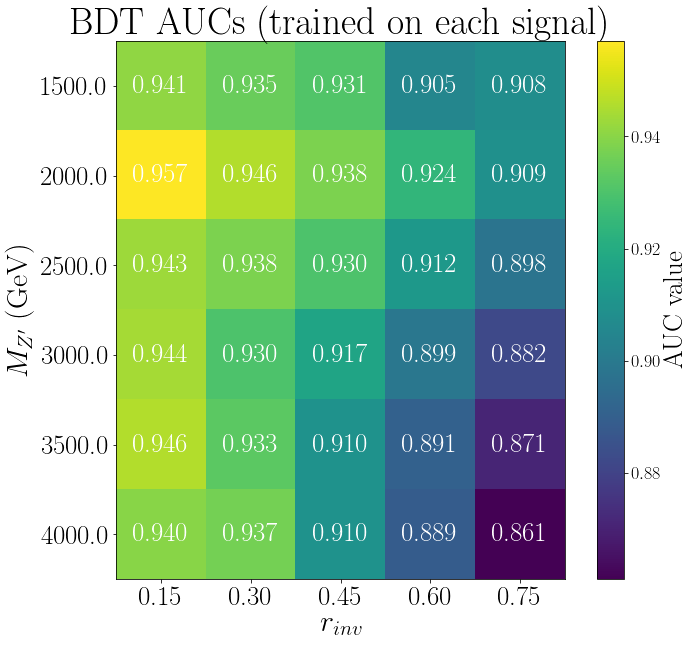

In [24]:
plot_signal_aucs_from_lp(bdts, title='BDT AUCs (trained on each signal)')

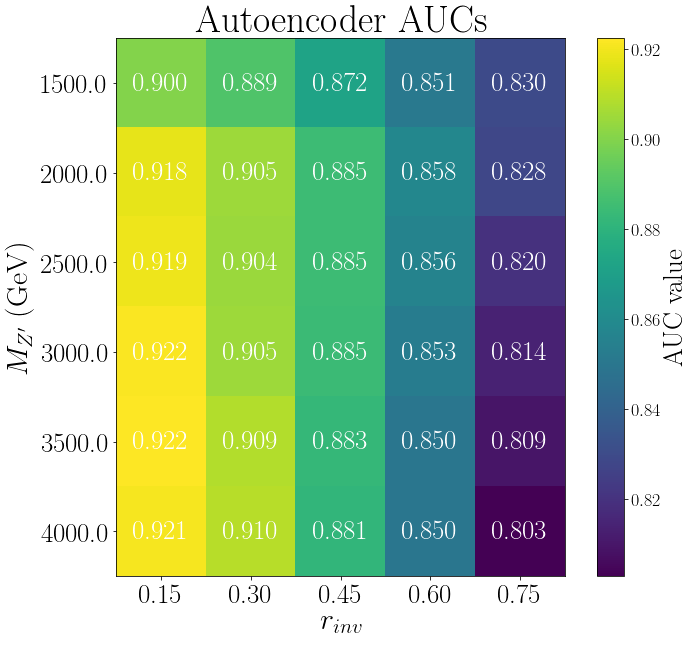

In [25]:
best,ax = plot_signal_aucs(aucs, title='Autoencoder AUCs')

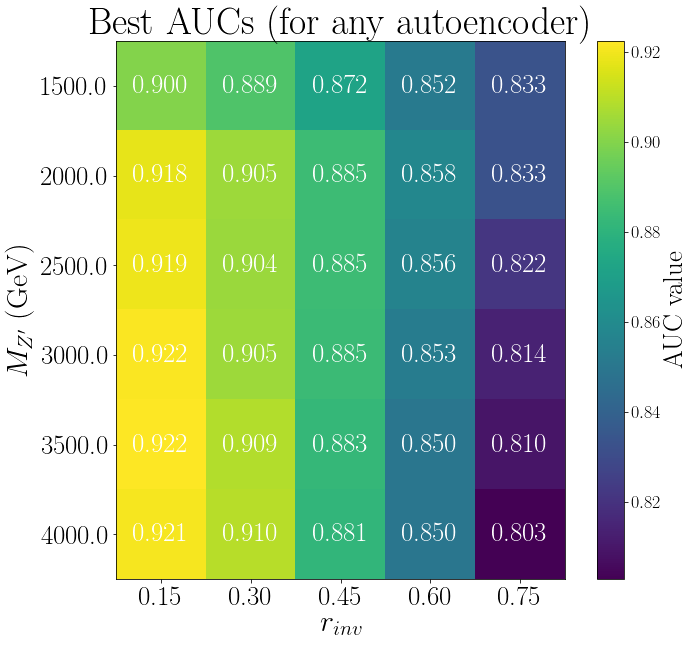

In [26]:
overall,ax = plot_signal_aucs(aucs, do_max=True)

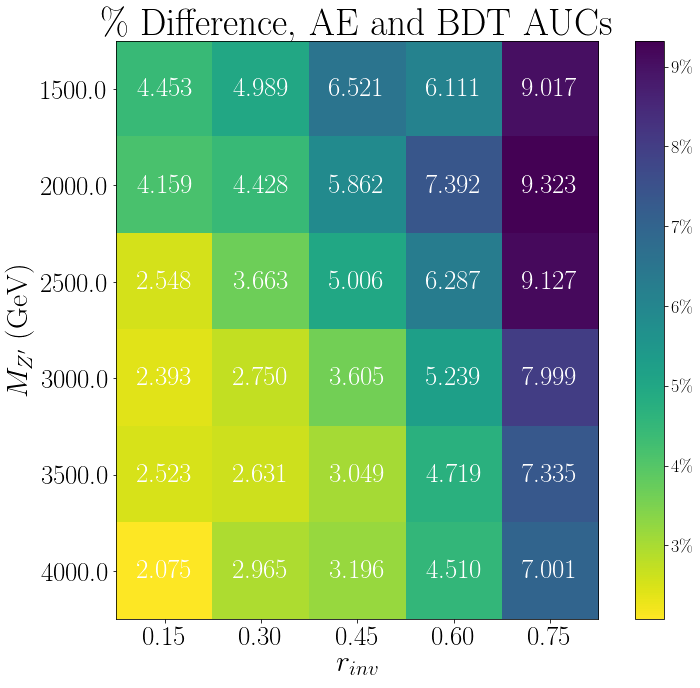

In [27]:
diff = (bdts - best) / ((bdts + best)/2.)*100.
ax = plot_signal_aucs_from_lp(diff, title='\% Difference, AE and BDT AUCs', barlabel='', cmap='viridis_r')
ax.images[-1].colorbar.remove()
cb = plt.colorbar(ticks=range(2,10))
cb.ax.set_yticklabels(['{}\%'.format(x) for x in range(3,10)])

plt.tight_layout()
plt.show()

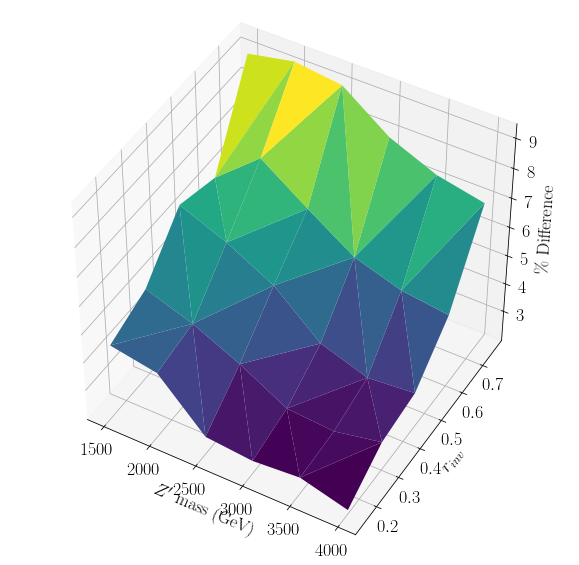

In [28]:
from mpl_toolkits import mplot3d


arr_to_3d = diff.copy()
x, y, z, = np.asarray(pd.melt(arr_to_3d.reset_index(), id_vars='index').values).astype(float).T

fig = plt.figure()
# x = np.tile(varc.index, [len(varc.columns),1,]).T
# y = np.tile(varc.columns, [len(varc.index),1])
# z = varc.values
ax = plt.axes(projection='3d')
ax.plot_trisurf(x,y,z,cmap='viridis')
ax.view_init(45, 270 + 30)
ax.set_xlabel(r'$Z^\prime$ mass (GeV)')
ax.set_ylabel(r'$r_{inv}$')
ax.set_zlabel(r'\% Difference')
plt.show()

In [29]:
def histby(aucs, category, bins=20, lines=False, stacked=False, histtype='step', alpha=1, cat_name=None):
    if cat_name is None:
        cat_name = category
    tab = aucs.reset_index()
    cats = ['mass', 'nu']
    tab['mass'] = tab.mass_nu_ratio.map(lambda x: x[0])
    tab['nu'] = tab.mass_nu_ratio.map(lambda x: x[1])
    tab = tab.drop('mass_nu_ratio', axis=1)
    
    tab = tab.drop([m for m in cats if m != category], axis=1)
    groups = tab.groupby(category).apply(lambda x: x.values.flatten())
    
    
    rng = aucs.values.min(), aucs.values.max() 
    if stacked:
        histtype=None
    
    if lines:
        vals = np.linspace(rng[0], rng[1], bins + 1)
        cnts = np.asarray([np.histogram(g, bins=vals)[0] for g in np.asarray(groups.values)])
        
        x = vals[:-1] + np.diff(vals)/2
        ys = np.asarray(cnts)
        for y,label in zip(ys, groups.index):
            plt.plot(x, y, label=label)
        plt.legend(title=cat_name)
        
        return plt.gca()

    rets = plt.hist(np.asarray(groups.values), bins=bins, range=rng, stacked=stacked, alpha=alpha, histtype=histtype, label=[val for val in groups.index])
    plt.legend(title=cat_name)
    return plt.gca()


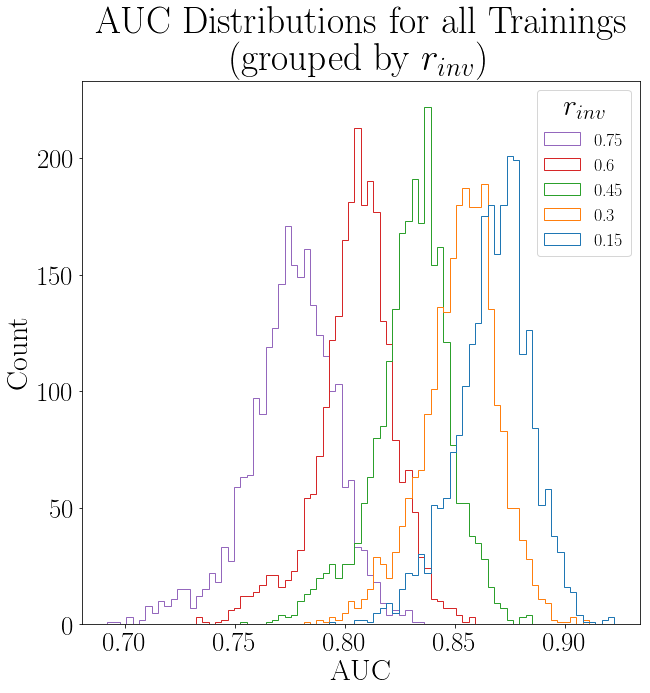

In [30]:
fac = 1.5
ax = histby(aucs, 'nu', lines=False, alpha=1, histtype='step', bins=80, cat_name='$r_{inv}$')
lg = plt.legend(fontsize=12*fac, title=r'$r_{inv}$')
lg.get_title().set_fontsize(20*fac) 
plt.title('AUC Distributions for all Trainings\n(grouped by $r_{inv}$)', fontsize=25*fac)
plt.ylabel('Count', fontsize=20*fac)
plt.xlabel('AUC', fontsize=20*fac)
plt.xticks(fontsize=18*fac)
plt.yticks(fontsize=18*fac)
plt.show()

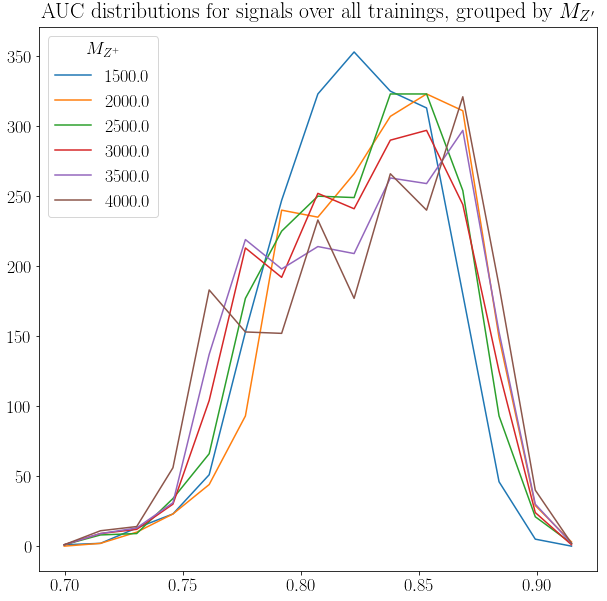

In [31]:
ax = histby(aucs, 'mass', lines=True, alpha=1, histtype='step', bins=15, cat_name='$M_{Z^+}$')
plt.title('AUC distributions for signals over all trainings, grouped by $M_{Z^\prime}$')
plt.show()

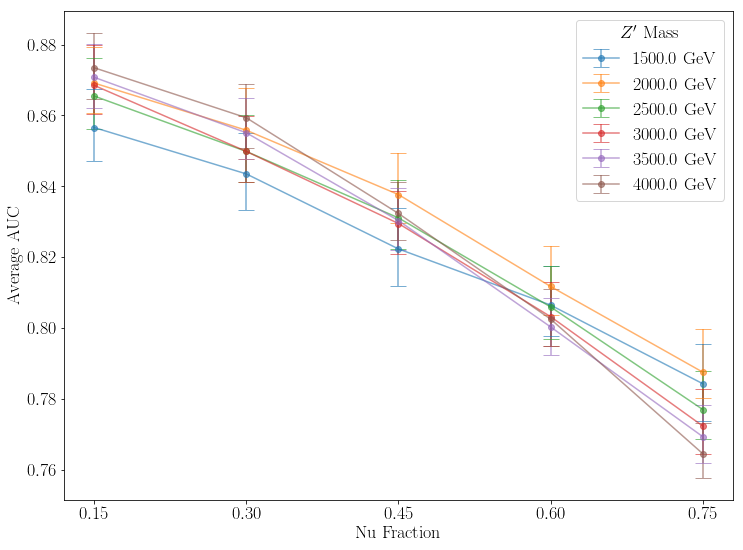

In [32]:
import scipy.stats

def plot_nu_vs_aucs(aucs, n=None):

    sort = aucs.loc[:,aucs.mean().sort_values()[::-1].index]
    # c = 5
    if n is None:
        n = len(sort.columns)
        
    subset = sort.iloc[:,:n]
    
    means = subset.mean(axis=1)
    mid = np.percentile(aucs, 50, axis=1)
    lower = mid - np.percentile(aucs, 75, axis=1)
    upper = np.percentile(aucs, 25, axis=1) - mid
    bars = np.asarray([upper, lower]).T
    
    
    masses, nus = np.asarray(map(np.asarray, means.index)).T
    mean_vals = means.values

    
    plt.figure(figsize=(12,9))
    
    for mass in sorted(set(masses)):
        idx = masses == mass
        
        plt.errorbar(nus[idx], mean_vals[idx], marker='o', yerr=bars[idx].T, label='{} GeV'.format(mass), capsize=8.0, alpha=0.6)
        
    
    plt.xlabel('Nu Fraction')
    plt.ylabel('Average AUC')
    plt.xticks(np.unique(nus))
    plt.legend(title=r'$Z^{\prime}$ Mass')
    plt.title('')
    plt.show()
#     return means, lower, upper
    
plot_nu_vs_aucs(aucs)

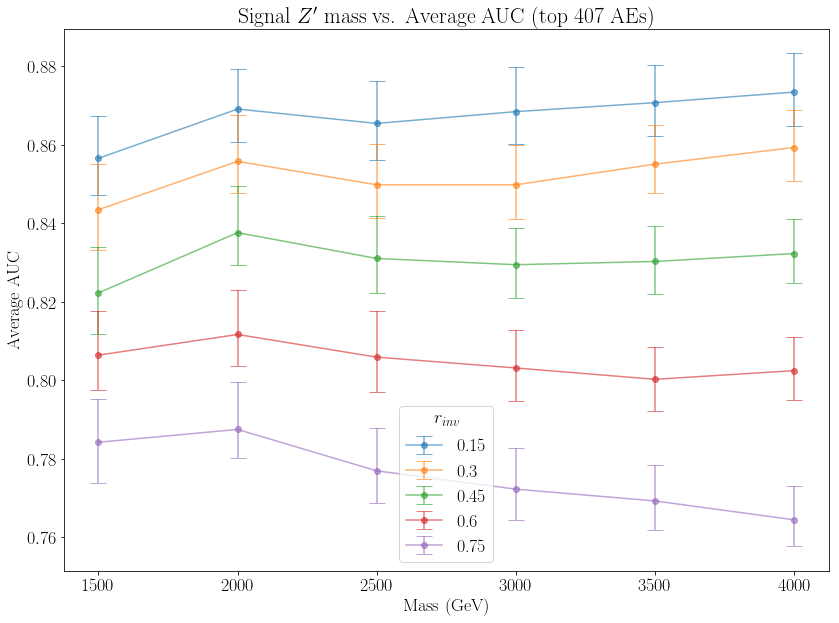

In [33]:
def plot_mass_vs_aucs(aucs, n=None):
    
    sort = aucs.loc[:,aucs.mean().sort_values()[::-1].index]
    # c = 5
    if n is None:
        n = len(sort.columns)
        
    subset = sort.iloc[:,:n]
    
    means = subset.mean(axis=1)
    mid = np.percentile(aucs, 50, axis=1)
    lower = mid - np.percentile(aucs, 75, axis=1)
    upper = np.percentile(aucs, 25, axis=1) - mid
    bars = np.asarray([upper, lower]).T
    
    
    masses, nus = np.asarray(map(np.asarray, means.index)).T
    mean_vals = means.values
    
    plt.figure(figsize=(12,9))
    
    for nu in sorted(set(nus)):
        idx = nus == nu
        plt.errorbar(masses[idx], mean_vals[idx], marker='o', yerr=bars[idx].T, label='{}'.format(nu), capsize=8.0, alpha=0.6)
        
    plt.xlabel('Mass (GeV)')
    plt.ylabel('Average AUC')
    plt.xticks(np.unique(masses))
    plt.legend(title=r'$r_{inv}$')
    plt.title('Signal $Z^\prime$ mass vs. Average AUC (top {} AEs)'.format(n))
    plt.tight_layout()
    plt.show()
    
plot_mass_vs_aucs(aucs)

# important
`data_holder` basically loads all signal data into memory at once, while `auc_getter` gets and generates errors, reconstructed data, and normalized data on a gievn training run. Both of these things are critical to the later plotting

In [82]:
reload(ev)

<module 'autoencodeSVJ.evaluate' from '/afs/cern.ch/user/l/llepotti/.local/lib/python2.7/site-packages/autoencodeSVJ/evaluate.pyc'>

In [83]:
eflow_base = 3

dholder = ev.data_holder(
    qcd='data/background/base_3/*.h5',
    **{os.path.basename(p): '{}/base_{}/*.h5'.format(p, eflow_base) for p in glob.glob('data/all_signals/*')}
)

dholder.load()
dists = {v.name: v for v in dholder.get('data')}

# signal = utils.data_table(pd.concat([v.df for v in dists.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')
qcd = dists['qcd']

found 31 datasets


In [84]:
dists_subset = [v for v in dists.values() if v.name.startswith('Zprime')]
size = min(map(len, dists_subset))
signal = utils.data_table(pd.concat([v.df.iloc[:size] for v in dists_subset]), name='Z^+ Dark (Average)')

In [85]:
signal_combined = pd.concat([pd.concat([v.df, pd.Series(np.repeat(k, len(v)), name='key')], axis=1) for k,v in dists.items() if k.startswith('Zprime')])

In [86]:
sc = signal_combined

sc['mass'] = sc.key.apply(lambda x: int(x.split('_')[1].rstrip('GeV')))
sc['nu'] = sc.key.apply(lambda x: float(x.split('_')[-1])/100.)
sc.head()

,Eta,Phi,Pt,M,ChargedFraction,PTD,Axis2,eflow 1,eflow 2,eflow 3,...,eflow 6,eflow 7,eflow 8,eflow 9,eflow 10,eflow 11,eflow 12,key,mass,nu
0,0.045230,-2.963542,1060.937012,72.560196,0.542857,0.422861,0.012878,0.109822,0.043440,0.026606,...,0.005165,0.013676,0.004245,0.012061,0.004771,0.002950,0.001325,Zprime_1500GeV_075,1500,0.75
1,-0.517251,0.734206,218.460312,22.048283,0.419355,0.235611,0.058614,0.267471,0.136899,0.091385,...,0.036999,0.050795,0.032694,0.071541,0.036616,0.026557,0.019135,Zprime_1500GeV_075,1500,0.75
2,0.747401,-1.752697,764.918213,111.881714,0.438596,0.225167,0.053749,0.201216,0.106203,0.070189,...,0.020981,0.037083,0.018470,0.040488,0.021370,0.014068,0.008147,Zprime_1500GeV_075,1500,0.75
3,0.239115,0.777392,413.002228,26.284382,0.370370,0.298932,0.029016,0.178803,0.086328,0.055347,...,0.016149,0.029420,0.013739,0.031970,0.015436,0.010216,0.005716,Zprime_1500GeV_075,1500,0.75
4,1.403882,1.920689,681.028625,48.152981,0.464286,0.605886,0.007971,0.116954,0.062411,0.040772,...,0.007477,0.020941,0.006304,0.013678,0.007299,0.004326,0.001600,Zprime_1500GeV_075,1500,0.75


In [139]:
tf.reset_default_graph()
agetter = ev.auc_getter('hlf_eflow3_8_v36', times=True)
agetter.update_event_range(dholder, percentile_n=1)
norm, errors, recon = agetter.get_errs_recon(dholder)
aucs_ = agetter.get_aucs(errors)
fmt = agetter.auc_metric(aucs_)

signal_recon = utils.data_table(pd.concat([v.df.iloc[:size] for v in recon.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average) pred')
signal_norm = utils.data_table(pd.concat([v.df.iloc[:size] for v in norm.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')
signal_err = utils.data_table(pd.concat([v.df.iloc[:size] for v in errors.values() if v.name.startswith('Zprime')]), name='Z^+ Dark (Average)')

found 1 matches with search '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/summary/hlf_eflow3_8_v36.summary'
:: TIME: init executed in 1.09 s
:: TIME: test dataset executed in 0.04 s
train_shell :: using saved model
:: TIME: recon gen executed in 25.37 s
:: TIME: auc grab executed in 0.61 s


In [88]:
styles = {
    'Z': {
        'facecolor': 'm',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'SVJ',
        'alpha': 0.4,
#         'hatch': '/'
    },
    'qcd': {
        'facecolor': 'y',
        'histtype': 'step',
        'fill': True,
        'edgecolor': 'k',
        'label': r'QCD',
        'alpha': 0.4

    },
    'ttbar': {
        'facecolor': 'C0',
        'label': r'$t\bar{t}$',
        'edgecolor': 'w',
        'hatch': '//',
        'fill': True,
        'histtype': 'step',
        'alpha': 0.4

    }
}

order = [
    'ttbar',
    'Z',
    'qcd'
]


var_styles = {
    'ChargedFraction': {
        'xlabel': r'Charged Fraction',
        'fontsize': 20,
    },
    'Pt': {
        'xlabel': r'$\displaystyle p_{T}$',
        'fontsize': 20,
        'range': (0., 2000.),
    },
    'Eta': {
        'xlabel': r'$\displaystyle \eta$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'Phi': {
        'xlabel': r'$\displaystyle \phi$',
        'fontsize': 20,
#         'range': (0., 0.7),
    },
    'M': {
        'xlabel': 'Mass',
        'fontsize': 20,
        'range': (0., 500.)
    },
    'mae': {
        'xlabel': 'Reconstruction Error (MAE)',
        'fontsize': 30,
    },
    'PTD': {
        'xlabel': 'PTD',
        'fontsize': 20,
    },
    'Axis2': {
        'xlabel': 'Axis_2',
        'fontsize': 20,
        'range': (0, 0.2)
    }
}

# more than needed
for i in range(100):
    var_styles['eflow {}'.format(i)] = {}
    var_styles['eflow {}'.format(i)]['xlabel'] = "Variable {}".format(i)
    var_styles['eflow {}'.format(i)]['fontsize'] = 20

eflow_ranges = {
    1: (0,0.6),
    2: (0,0.5),
    3: (0,0.4),
    4: (0,0.4),
    5: (0,0.25),
    6: (0,0.15),
    7: (0,0.2),
    8: (0,0.15),
    9: (0,0.3),
    10: (0,0.2),
    11: (0,0.15),
    12: (0,0.15)
}

for num,rng in eflow_ranges.items():
    var_styles['eflow {}'.format(num)]['range'] = rng

### Pre-use histograms

Thing to convert data into column-based shit:

In [89]:
from collections import OrderedDict

def converter(toplot): 
    colsets = [tuple(x.columns) for x in toplot.values()]
    assert(len(set(colsets)) == 1)
    var = colsets[0]

    names = sorted(toplot.keys())

    out = OrderedDict()
    for name in names:
        for v in var:
            if v not in out:
                out[v] = OrderedDict()
            out[v][name] = toplot[name][v]

    return out

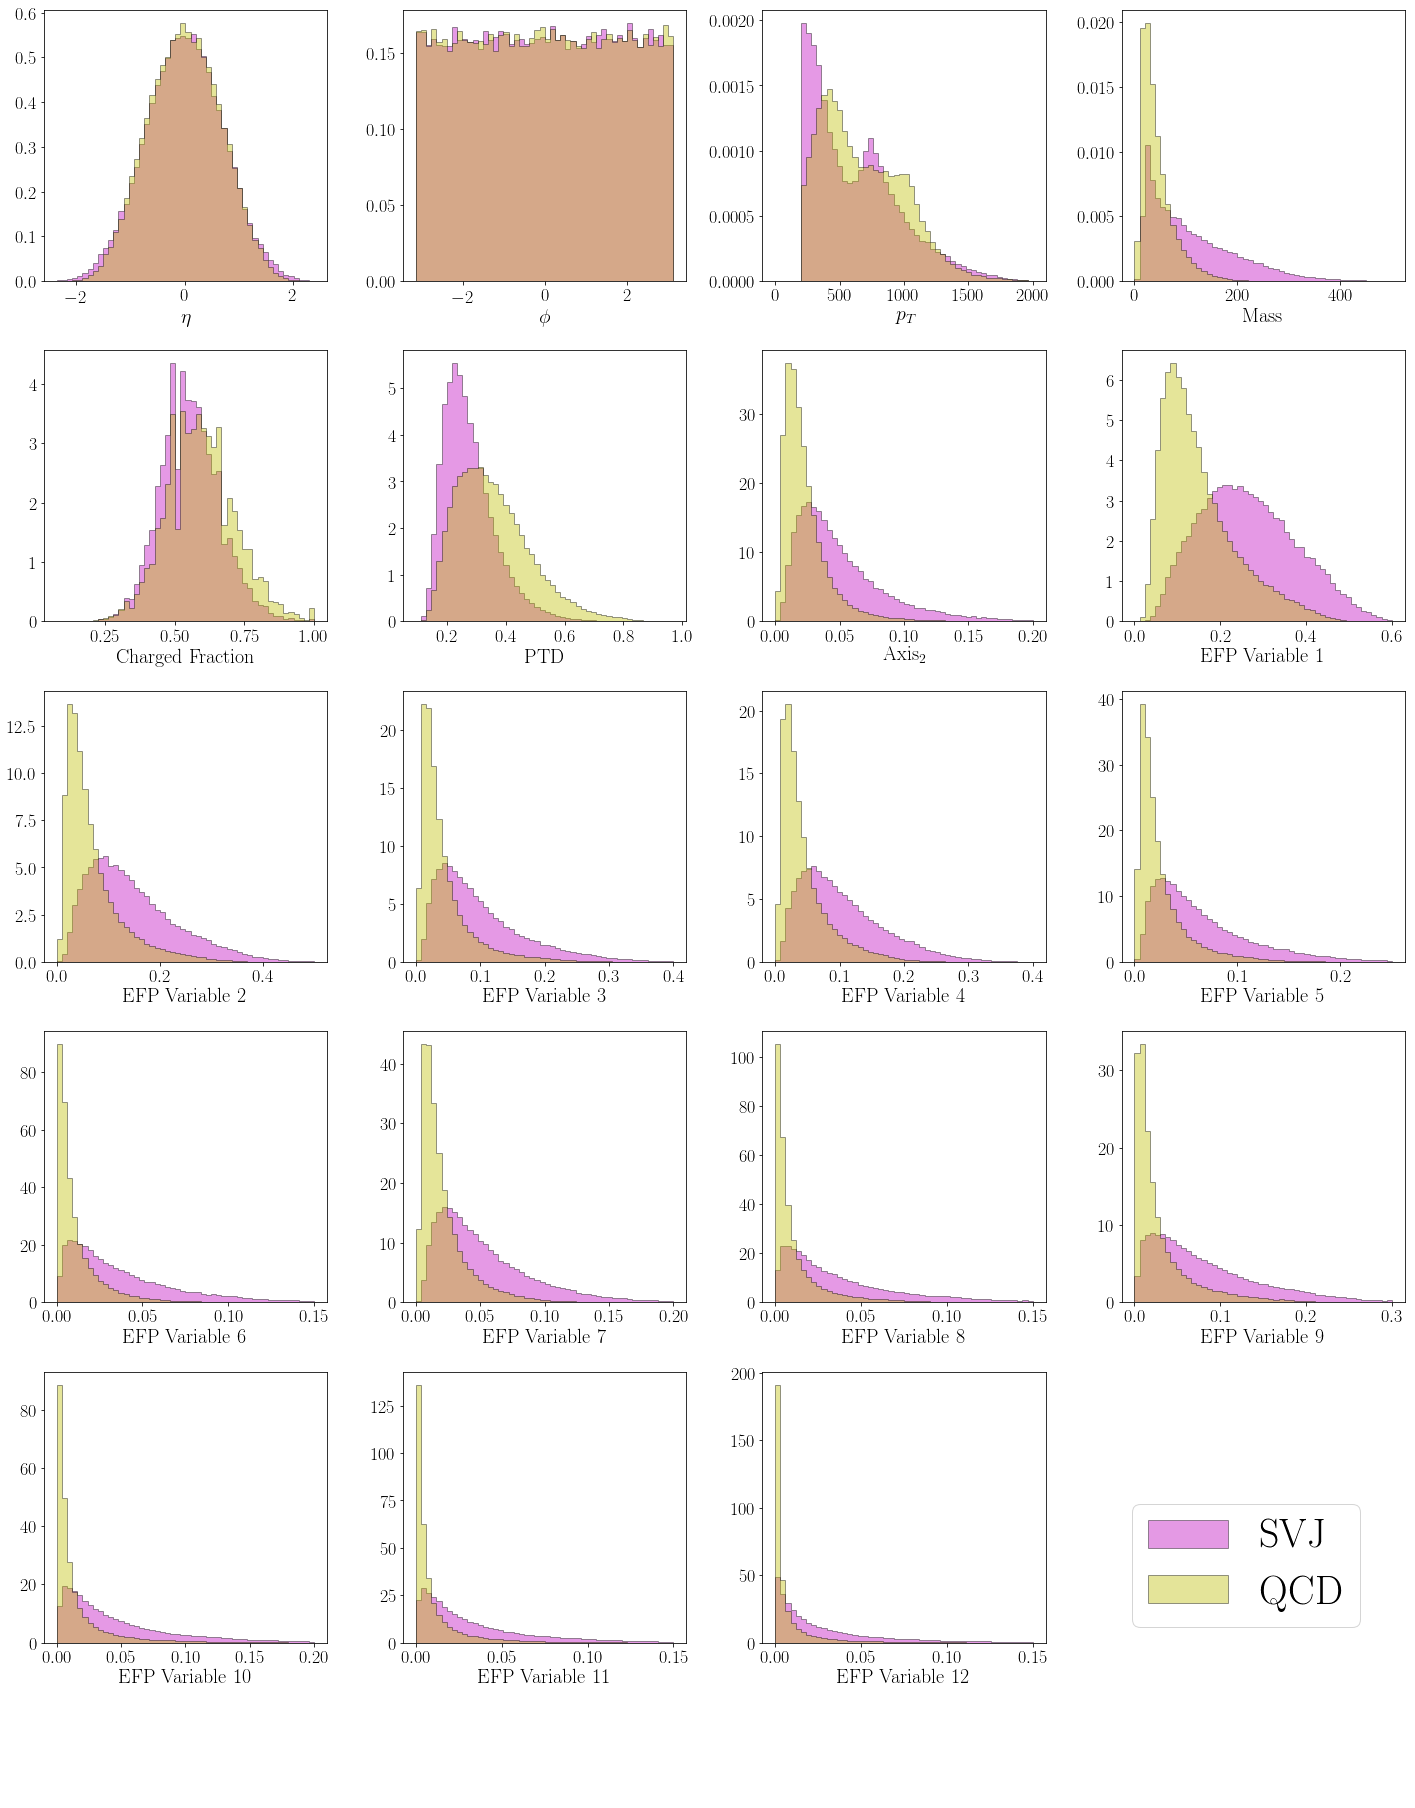

In [138]:
data = converter({'Z': signal, 'qcd': qcd})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 20./4.
m2 = 14./3.


fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins
i = 0
for d,v in data.items():
    var_style = var_styles[d].copy()

    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')
    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[k].copy()

#             style['alpha'] = 0.3
        ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)


        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(0.8, 0.1), fontsize=40)
for x in axs[i:]:
    f.delaxes(x)


### Post-all

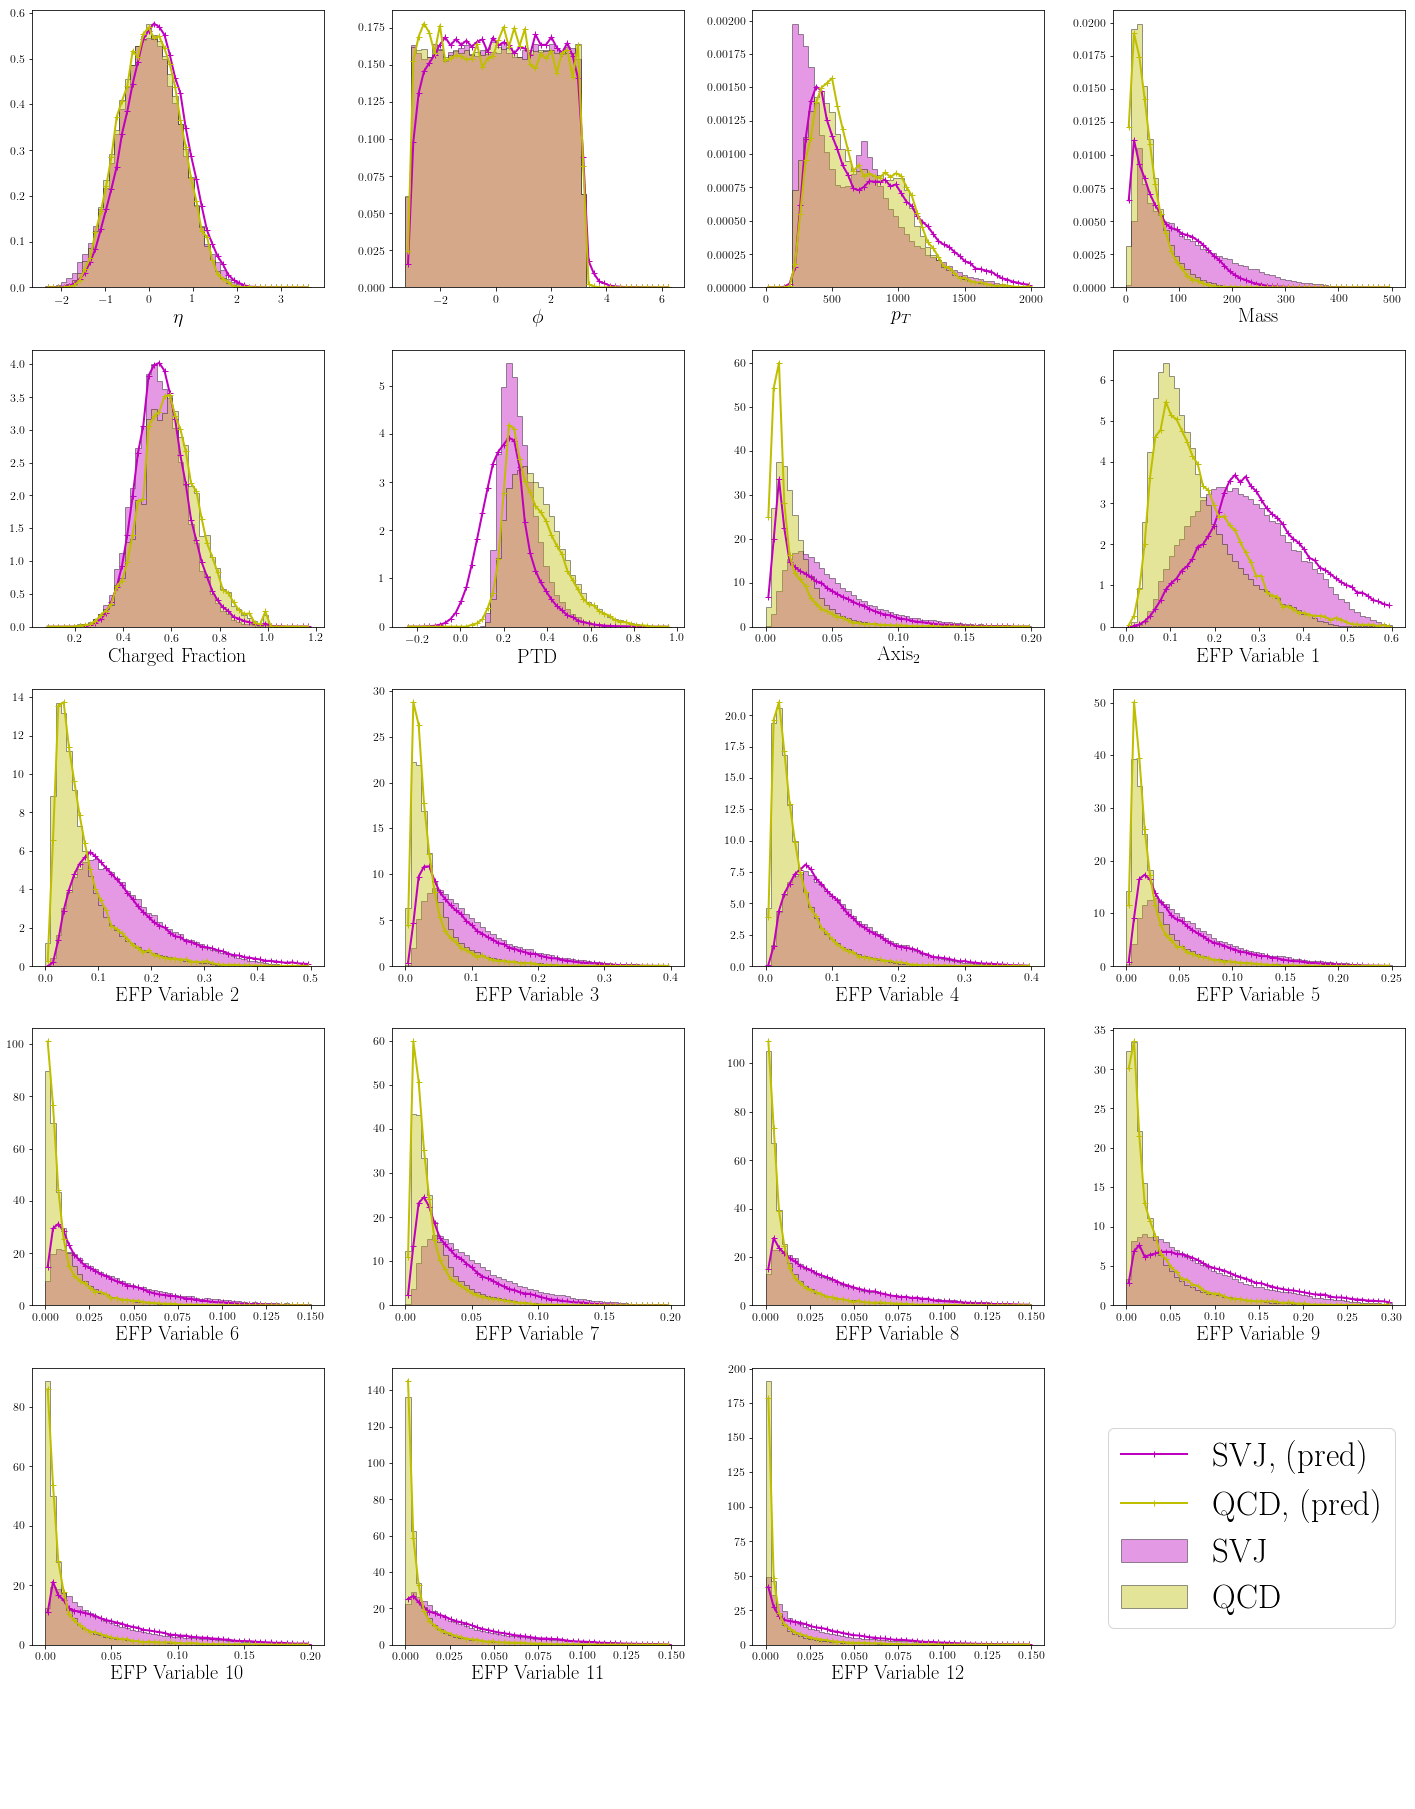

In [91]:
data = converter({
    'Z pred': signal_recon,
    'qcd pred': recon['qcd pred'],
    'Z': signal, 
    'qcd': dists['qcd']
})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 20./4.
m2 = 14./3.

recon_kwd = 'pred'
# dists = e.dists_dict.copy()
# dists['qcd'] = e.test
# data = plotdata({recon_kwd : e.recons_dict, 'NONE': dists}, names=names)

fs = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
# f.suptitle("Feature Reconstructions", y=1.02, fontsize=30)
ogbins = bins
i = 0

for da,v in data.items():
    
    var_style = var_styles[da].copy()
    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
    
    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')

    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]
        reconstructed = False
        kp = k 
        if recon_kwd in k:
            reconstructed = True 

            kp = k.replace(recon_kwd, '').strip()

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[kp].copy()

#             style['alpha'] = 0.3
        if reconstructed:
            hist,bins = np.histogram(datum, range=rng, bins=nbins, normed=normed)

            style['color'] = style['facecolor']
            style['linewidth'] = 2
            style['label'] = style['label'] + ', (pred)'
            for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
                if var in style:
                    style.pop(var)

            ax.plot(bins[:-1] + np.diff(bins)/2., hist, marker='+', alpha=1, **style)
#                 ax.scatter(bins[:-1] + np.diff(bins)/2., hist, marker='+', edgecolor='k', **style)
        else:
            ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7825,.1), fontsize=33)
for x in axs[i:]:
    f.delaxes(x)

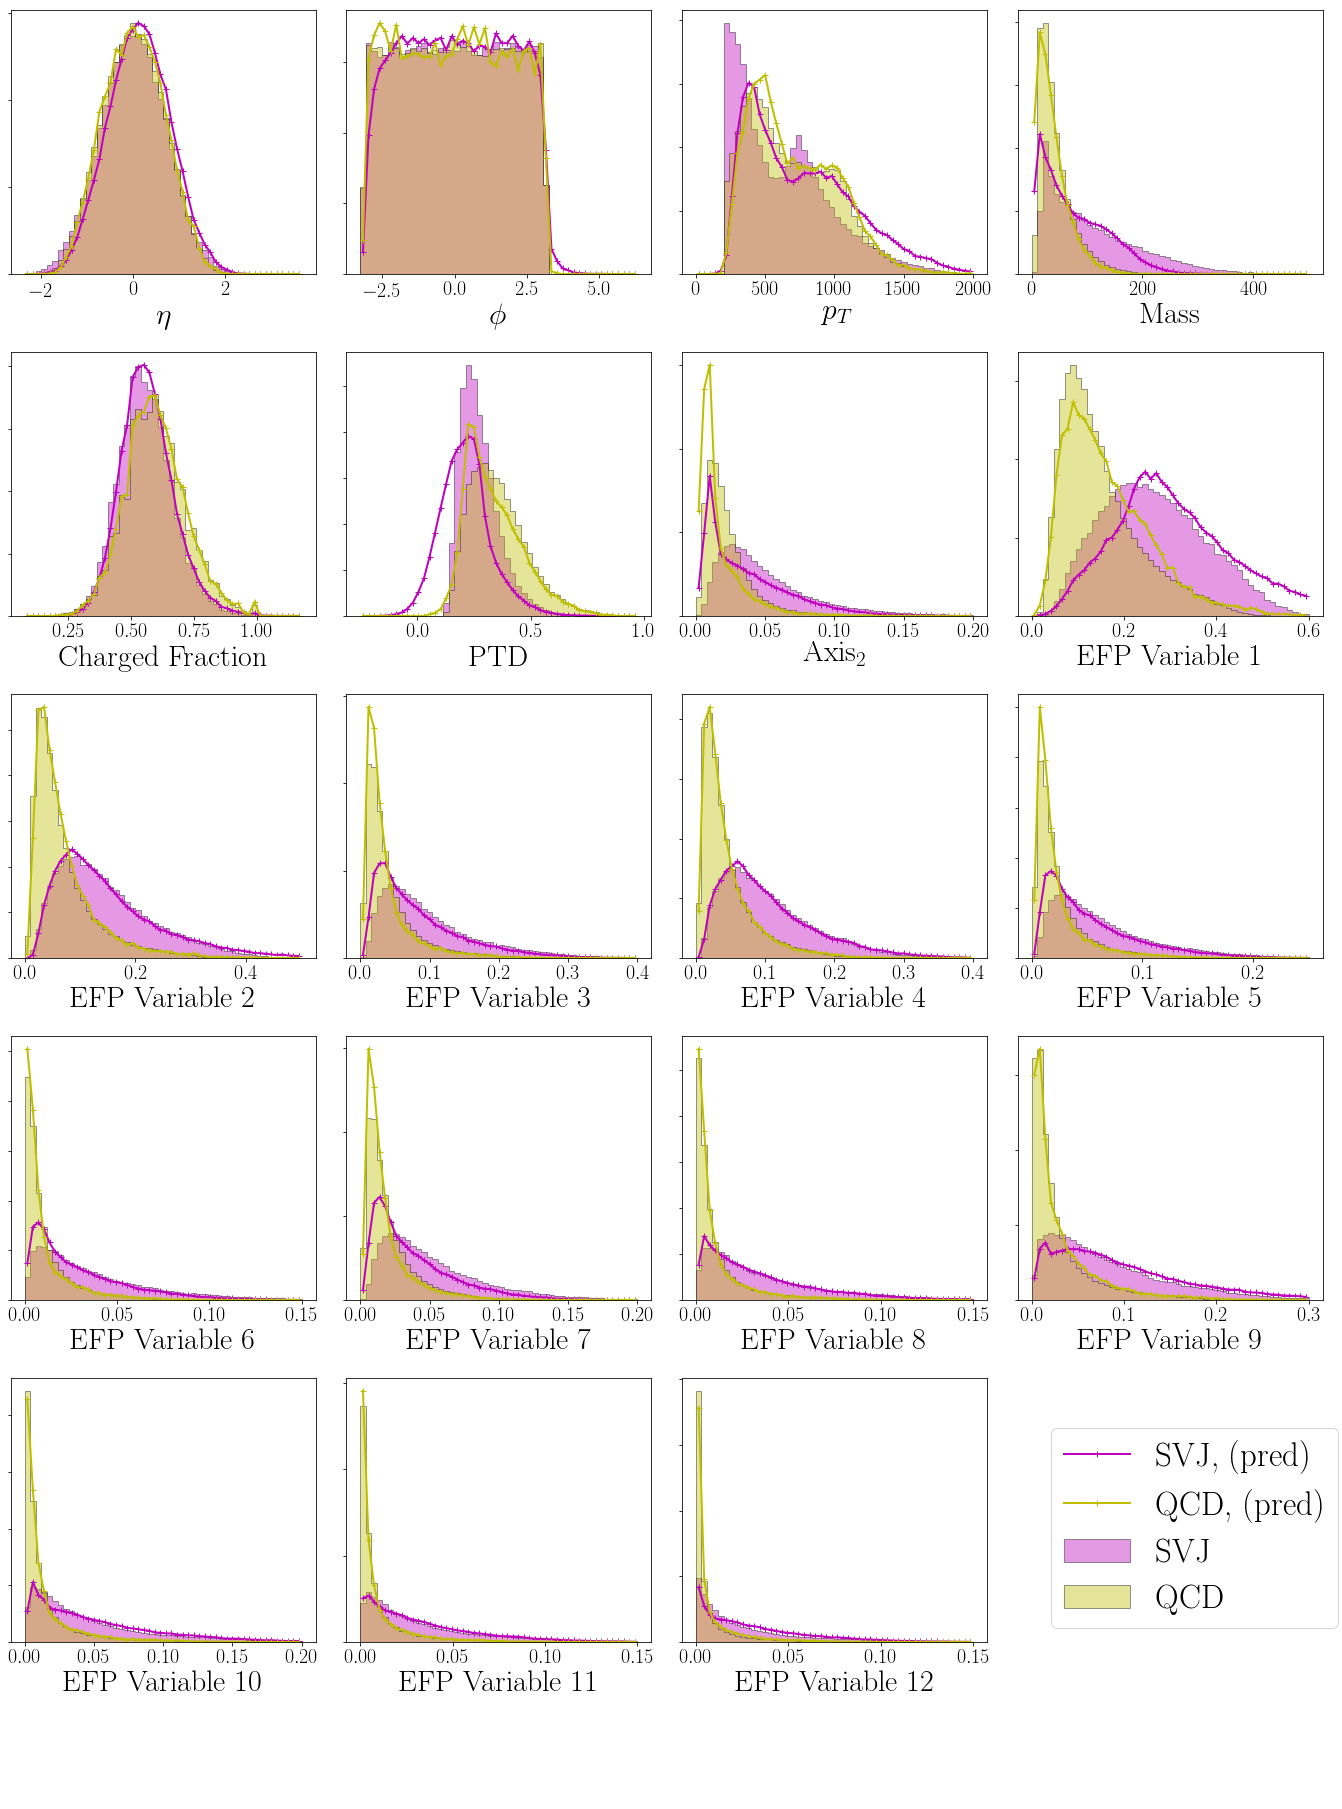

In [92]:
data = converter({
    'Z pred': signal_recon,
    'qcd pred': recon['qcd pred'],
    'Z': signal, 
    'qcd': dists['qcd']
})

bins=50
names="*"
ylabel=None
normed=1
xlog=False
ylog=False
pileup=False
m1 = 19./4.
m2 = 14./3.

recon_kwd = 'pred'
# dists = e.dists_dict.copy()
# dists['qcd'] = e.test
# data = plotdata({recon_kwd : e.recons_dict, 'NONE': dists}, names=names)

fs = 20
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 18})

rows, cols = (6,4)
f, axs = plt.subplots(rows, cols, figsize=(cols*m1, rows*m2))
axs = axs.flatten()
# f.suptitle("Feature Reconstructions", y=1.02, fontsize=30)
ogbins = bins
i = 0

for da,v in data.items():
    
    var_style = var_styles[da].copy()
    if 'Variable' in var_style['xlabel']:
        var_style['xlabel'] = "EFP " + var_style['xlabel'] 
    
    if 'bins' in var_style:
        bins = var_style.pop('bins')
    else:
        bins = ogbins

    if 'range' in var_style:
        rng = var_style.pop('range')

    else:
        rng = map(lambda f: f(map(f, v.values())), [min, max])
    ax = axs[i]

#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
    for k in v.keys():

        datum = v[k]
        reconstructed = False
        kp = k 
        if recon_kwd in k:
            reconstructed = True 

            kp = k.replace(recon_kwd, '').strip()

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[kp].copy()

#             style['alpha'] = 0.3
        if reconstructed:
            hist,bins = np.histogram(datum, range=rng, bins=nbins, normed=normed)

            style['color'] = style['facecolor']
            style['linewidth'] = 2
            style['label'] = style['label'] + ', (pred)'
            for var in ['histtype', 'fill', 'facecolor', 'edgecolor', 'hatch', 'alpha']:
                if var in style:
                    style.pop(var)

            ax.plot(bins[:-1] + np.diff(bins)/2., hist, marker='+', alpha=1, **style)
#                 ax.scatter(bins[:-1] + np.diff(bins)/2., hist, marker='+', edgecolor='k', **style)
        else:
            ax.hist(datum, range=rng, bins=nbins, normed=normed, **style)

        var_style['fontsize'] = 30
        ax.set_xlabel(**(var_style))
        
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        ax.set_yticklabels([])

    i += 1

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7825,.1), fontsize=33)
for x in axs[i:]:
    f.delaxes(x)

Text(0,0.5,u'Count')

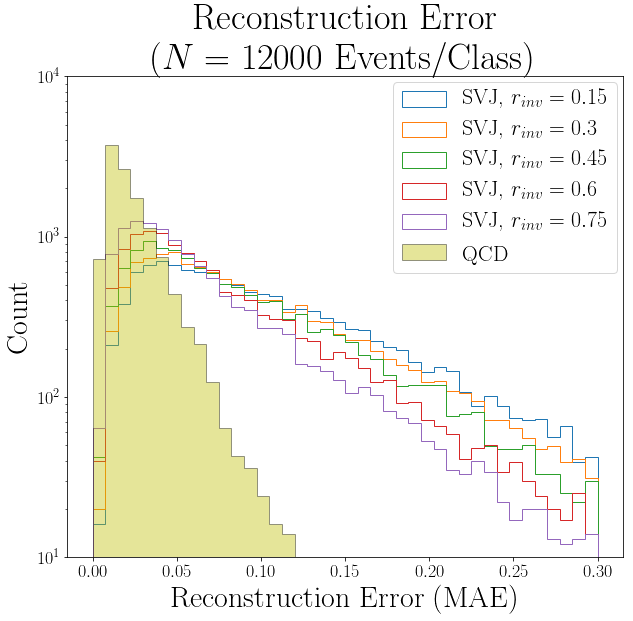

In [98]:
import random

N0 = 12000

# N = 6*N0/5


keys = errors.keys()
keys.remove('qcd')
keys = pd.DataFrame(keys, columns=['key'])
keys['nu'] = keys.key.apply(lambda x: x.split('_')[-1]).astype(float)/100.
keys['mass'] = keys.key.apply(lambda x: x.split('_')[-2].replace('GeV', '')).astype(int)
se_idx = random.sample(list(set(signal_err.index)), N0/6)

newdata = {}
for nu, gp in keys.groupby('nu').key:
     newdata[nu] = pd.concat([errors[k].df.loc[se_idx] for k in gp])
    

# se_idx = random.sample(list(set(signal_err.index)), N//30)
qe_idx = random.sample(range(len(errors['qcd'])), N0)

inp = {'qcd': errors['qcd'].iloc[qe_idx]}
inp.update(newdata)
data = converter(inp)
data.pop('mse')
bins=40
ylabel=None
normed=0
xlog=False
ylog=True
pileup=False
rng=(0, 0.3)

#     recon_kwd = '(Reconstructed)'
#     data = plotdata(e.errs_dict, names=names, drop=drop)

fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 30})

#     rows, cols = (1,1)
f, ax = plt.subplots(1, 1, figsize=(2*m1, 2*m2))

#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins

stack = []
for d,v in data.items():
    if 'bins' in var_styles[d]:
        bins = var_styles[d].pop('bins')
    else:
        bins = ogbins

    if 'range' in var_styles[d]:
        rng = var_styles[d].pop('range')
    elif rng is None:
        rng = map(lambda f: f(map(f, v.values())), [min, max])


#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
       
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        if k in styles:
            style = styles[k].copy()
            ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)
        else:
            ax.hist(datum, range=rng,bins=nbins, normed=normed, label=r'SVJ, $r_{inv} = ' + '{}$'.format(str(k)), histtype='step')
            stack.append(np.histogram(datum, range=rng, bins=nbins, normed=normed))
            
        var_style = var_styles[d].copy()
        if 'Variable' in var_style['xlabel']:
            var_style['xlabel'] = "EFP " + var_style['xlabel'] 

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            plt.ylim(1e1,1e4)

            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

# ax.set_ylabel('Arbitrary Units')
# ax.set_yticklabels([])
# plt.yscale('log')

handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.62,.56), fontsize=22)
plt.title('Reconstruction Error\n($N$ = {} Events/Class)'.format(N0))
plt.ylabel('Count')



0.679029563044


Text(0,0.5,u'Count')

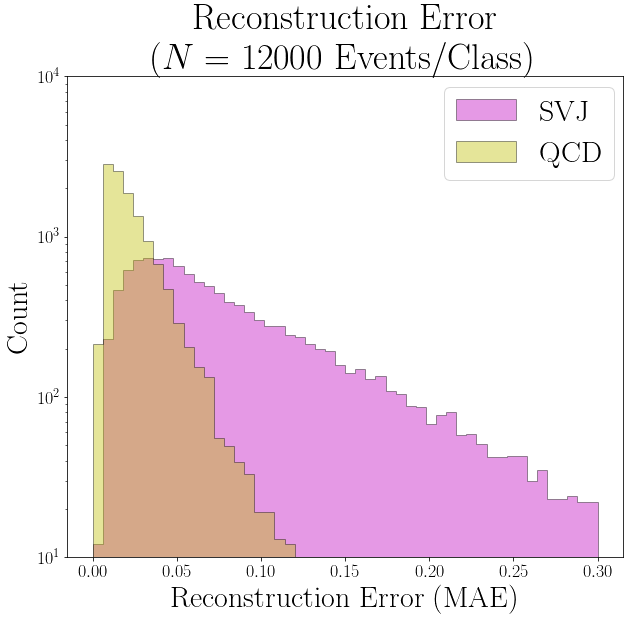

In [99]:
N = 12000

se_idx = random.sample(range(len(signal_err.index)), N)
qe_idx = random.sample(range(len(errors['qcd'])), N)
data = converter({'Z': signal_err.iloc[se_idx], 'qcd': errors['qcd'].iloc[qe_idx]})
data.pop('mse')
print(data['mae']['Z'].max())
bins=50
ylabel=None
normed=0
xlog=False
ylog=True
pileup=False
rng=(0, 0.3)
split=True

#     recon_kwd = '(Reconstructed)'
#     data = plotdata(e.errs_dict, names=names, drop=drop)

fs = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize']=fs
plt.rcParams['ytick.labelsize']=fs
matplotlib.rcParams.update({'font.size': 30})

#     rows, cols = (1,1)
f, ax = plt.subplots(1, 1, figsize=(2*m1, 2*m2))

#     f.suptitle("Input Variables", y=1.02, fontsize=30)
ogbins = bins

for d,v in data.items():
    if 'bins' in var_styles[d]:
        bins = var_styles[d].pop('bins')
    else:
        bins = ogbins

    if 'range' in var_styles[d]:
        rng = var_styles[d].pop('range')
    elif rng is None:
        rng = map(lambda f: f(map(f, v.values())), [min, max])


#         keys = reversed(sorted([k for k in v.keys() if len(k.split()) == 1]) + sorted([k for k in v.keys() if len(k.split()) > 1]))
       
    for k in v.keys():

        datum = v[k]

        if pileup:
            datum[datum < rng[0]] = rng[0]
            datum[datum > rng[1]] = rng[1]
        nbins = bins
        if xlog:
            nbins = np.geomspace(rng[0], rng[1], bins)

        style = styles[k].copy()

#             style['alpha'] = 0.3
        ax.hist(datum, range=rng,bins=nbins, normed=normed, **style)

        var_style = var_styles[d].copy()
        if 'Variable' in var_style['xlabel']:
            var_style['xlabel'] = "EFP " + var_style['xlabel'] 

        ax.set_xlabel(**(var_style))
#             ax.set_yscale('log')
        if xlog:
            ax.set_xscale('log')
        if ylog:
            plt.ylim(1e1,1e4)

            ax.set_yscale('log', nonposy='clip')
        if ylabel is not None:
            ax.set_ylabel(ylabel)

# ax.set_ylabel('Arbitrary Units')
# ax.set_yticklabels([])
# plt.yscale('log')
handles,labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc=(.7,.71), fontsize=30)
plt.title('Reconstruction Error\n($N$ = {} Events/Class)'.format(N))
plt.ylabel('Count')



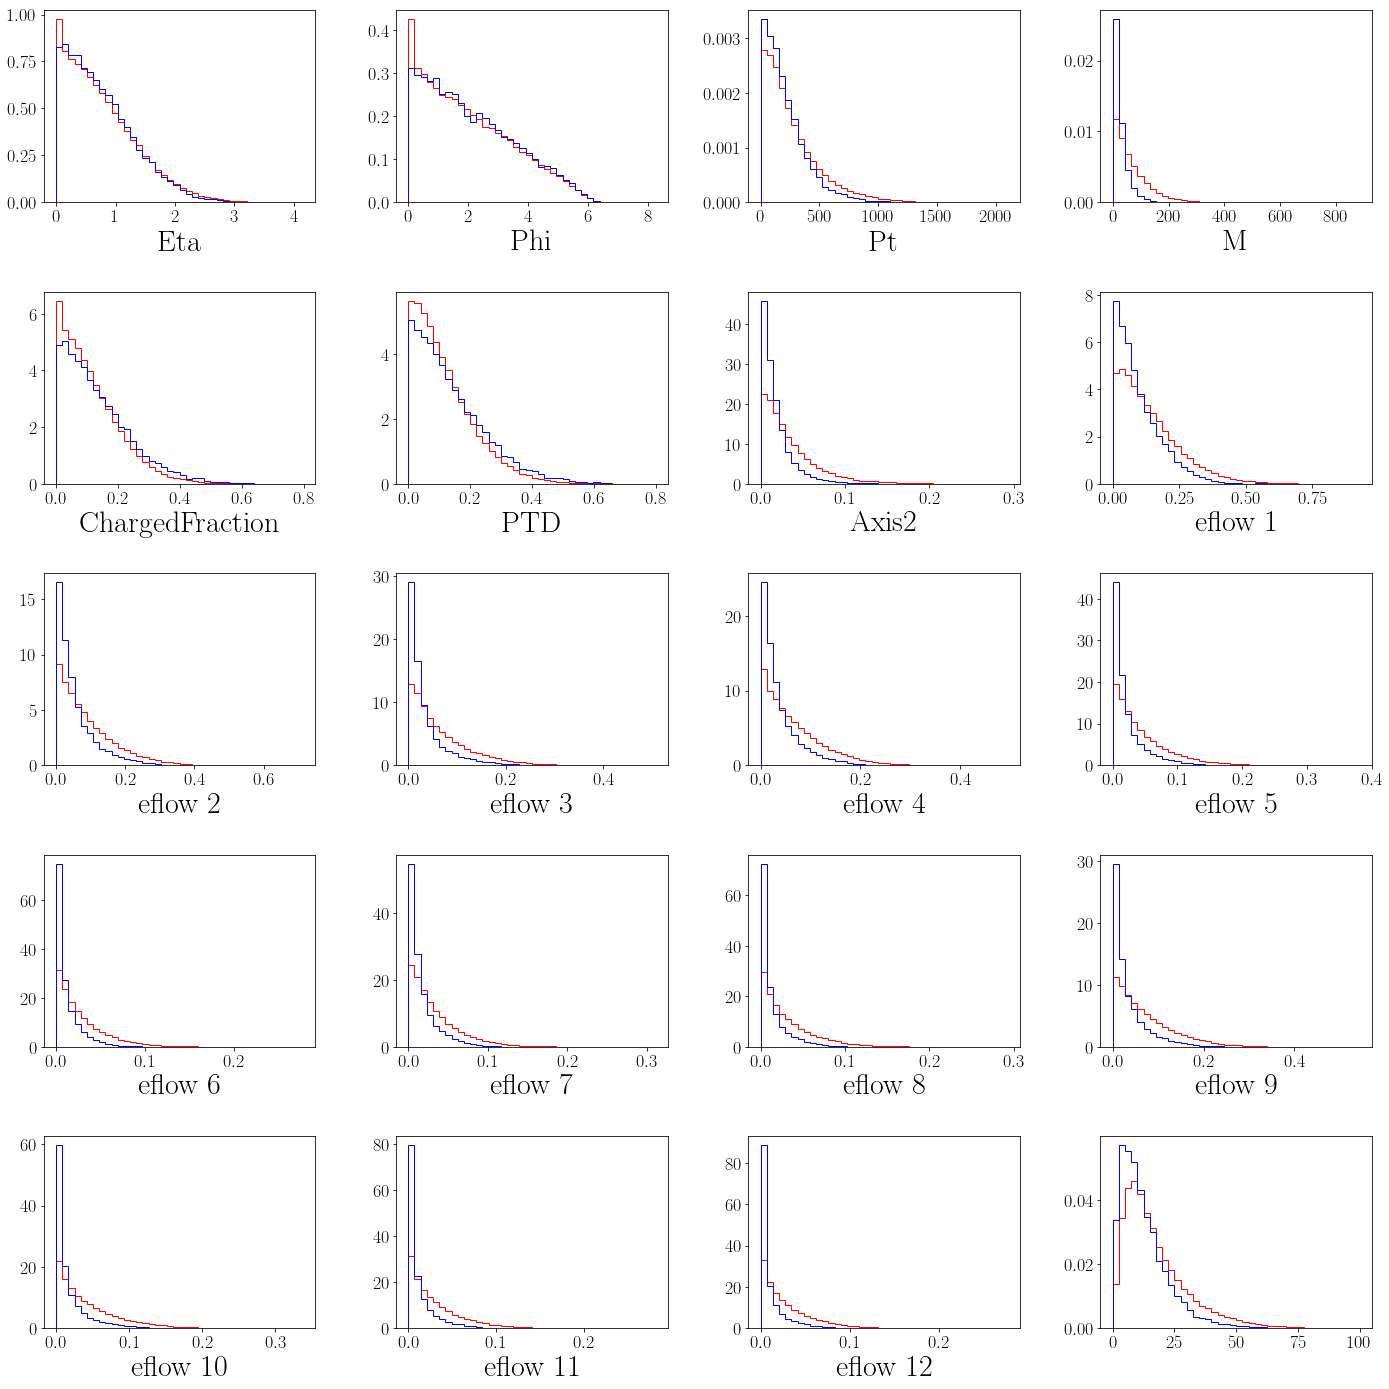

In [105]:
fig,axes = plt.subplots(5, 4, figsize=(20,20))

srecon = np.abs(signal_recon.reset_index(drop=True) - signal.reset_index(drop=True))
qrecon = np.abs(dists['qcd'].reset_index(drop=True) - recon['qcd pred'].reset_index(drop=True))

cols = srecon.columns
cnt = 0
for i in range(len(axes)):
    for j in range(len(axes[i])):
        if cnt >= len(cols):
            break
        ax = axes[i,j]
        
        c = cols[cnt]
        scol = srecon[c].values
        qcol = qrecon[c].values
        
        rng = min([scol.min(), qcol.max()]), max([scol.max(), qcol.max()])
        ax.hist(scol, range=rng, bins=40, color='red', histtype='step', normed=True)
        ax.hist(qcol, range=rng, bins=40, color='blue', histtype='step', normed=True)
        ax.set_xlabel(c)

        #.hist(ax=ax, bins=40, color='blue', histtype='step')
        cnt += 1

ax.hist([], range=rng, bins=40, color='red', histtype='step', label='svj')
ax.hist([], range=rng, bins=40, color='blue', histtype='step', label='qcd')
axes[i,j].hist(srecon.mean(axis=1), range=(0,100), color='red', histtype='step', bins=40, normed=1)
axes[i,j].hist(qrecon.mean(axis=1), range=(0,100), color='blue', histtype='step', bins=40, normed=1)
plt.legend()
plt.show()

In [106]:
import sklearn.metrics

se = signal_err
qe = errors['qcd']

# sklearn.metrics.auc(se qe)

In [107]:
maeroc = utils.roc_auc_dict([qe], [se], metrics='mae').values()[0]
# plt.plot(roc[0], roc[1])

# srecon = np.abs(signal_recon.reset_index(drop=True) - signal.reset_index(drop=True))
# qrecon = np.abs(dists['qcd'].reset_index(drop=True) - recon['qcd pred'].reset_index(drop=True))

roc = utils.roc_auc_dict([dists['qcd']], [signal], metrics=list(signal.columns)).values()[0]
roc.update(maeroc)

In [108]:
pd.DataFrame([[elt, roc[elt]['auc']] for elt in roc], columns=['var', 'auc']).sort_values('auc')[::-1]

# for elt in roc:
#     rocc = roc[elt]['auc']
#     print(elt, rocc)
#     plt.plot(rocc[0], rocc[1], label=elt)
    
# plt.legend()
# plt.show()

,var,auc
15,mae,0.875130
0,eflow 6,0.820396
1,eflow 7,0.813062
3,eflow 5,0.809171
12,eflow 8,0.808927
11,eflow 4,0.807670
17,eflow 11,0.804831
19,eflow 3,0.804165
4,eflow 2,0.802361
16,eflow 10,0.802309


In [127]:
signal.data

array([[  4.52304482e-02,  -2.96354222e+00,   1.06093701e+03, ...,
          4.77062101e-03,   2.95011316e-03,   1.32454701e-03],
       [ -5.17250776e-01,   7.34205902e-01,   2.18460312e+02, ...,
          3.66164090e-02,   2.65570065e-02,   1.91350658e-02],
       [  7.47401118e-01,  -1.75269687e+00,   7.64918213e+02, ...,
          2.13697517e-02,   1.40678766e-02,   8.14680495e-03],
       ..., 
       [ -9.13409144e-02,  -2.28559661e+00,   2.35118774e+02, ...,
          4.48388137e-02,   3.02314796e-02,   2.15280143e-02],
       [ -4.64351594e-01,   2.90588593e+00,   1.64794946e+03, ...,
          2.46438682e-02,   1.65694859e-02,   1.18836504e-02],
       [  2.02864692e-01,  -3.41008693e-01,   3.13052765e+02, ...,
          4.95095836e-02,   3.61275406e-02,   3.17462000e-02]])

array([[  1.06093701e+03,   7.25601959e+01,   5.42857143e-01, ...,
          4.77062101e-03,   2.95011316e-03,   1.32454701e-03],
       [  2.18460312e+02,   2.20482826e+01,   4.19354839e-01, ...,
          3.66164090e-02,   2.65570065e-02,   1.91350658e-02],
       [  7.64918213e+02,   1.11881714e+02,   4.38596491e-01, ...,
          2.13697517e-02,   1.40678766e-02,   8.14680495e-03],
       ..., 
       [  2.35118774e+02,   4.40250778e+01,   6.66666667e-01, ...,
          4.48388137e-02,   3.02314796e-02,   2.15280143e-02],
       [  1.64794946e+03,   3.55453857e+02,   5.97560976e-01, ...,
          2.46438682e-02,   1.65694859e-02,   1.18836504e-02],
       [  3.13052765e+02,   6.52810135e+01,   5.29411765e-01, ...,
          4.95095836e-02,   3.61275406e-02,   3.17462000e-02]])

In [135]:
def mae_minus1(true, pred):
    return np.abs((true[:,2:] - pred[:,2:])).mean(axis=1)
    
    
serr = utils.get_errors(signal.data, signal_recon.data, functions=[mae_minus1], names=['mae'])
qerr = utils.get_errors(dists['qcd'].data, recon['qcd'].data, functions=[mae_minus1], names=['mae'])

KeyError: 'qcd'

In [110]:
# from matplotlib import lines as mplines


# lone = agetter.get_aucs(err={v.name: v for v in [errors['qcd'], signal_err]})

# # errs = e.roc(figsize=10, yscale='log', xscale='log', figname='SVJ vs. QCD error', fontsize=20, show_plot=0)

# prop_cycle = plt.rcParams['axes.prop_cycle']
# all_colors = prop_cycle.by_key()['color']
# all_lines = ['-', '--', '-.', ':', '-']
# all_markers = ['x', 'o', 'd', '1', 's', '*']
# # all_lines = ["s", "o", "d", "x", "1"]
# aucplot = lone.copy()

# masses, nus = map(set, np.asarray([[a.split('_')[1], '{:.2f}'.format(int(a.split('_')[2])/100.)] for a in aucplot.keys()]).T)
# colors = {nu: all_colors[i] for i,nu in enumerate(nus)}
# lines = {nu: '-' for i,nu in enumerate(nus)}
# # markers = {mass: all_markers[i] for i,mass in enumerate(masses)}

# plt.figure(figsize=(10,10))

# used_labels = set()
# for a in aucplot:
#     for typ in aucplot[a]:
# #         mass,nu = a.split('_')[1:]
# #         nu = '{:.2f}'.format(int(nu)/100.)
#         roc = aucplot[a][typ]['roc']
#         auc = aucplot[a][typ]['auc']
#         lab = None
# #         lab = r'${}$'.format(nu)
# #         if lab in used_labels:
# #             lab = None
# #         used_labels.add(lab)
#         plt.plot(roc[0], roc[1], linestyle=lines[nu], c=colors[nu], label=r'$Z^+$ Dark (Avg.): AUC {:.4f}'.format(auc)) 
#     #, label=r'${}$, Nu={}'.format(mass, nu))
# plt.plot(np.arange(0,1.001,0.001), np.arange(0,1.001,0.001), linestyle='--', c='grey')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Signal Discrimination ROC Curve')
# # plt.yscale('log')
# # plt.xscale('log')
# plt.legend()
# # plt.ylim(1e-1, 1)
# # plt.xlim(1e-3, 1)

# plt.show()

In [142]:
from matplotlib import lines as mplines
# errs = e.roc(figsize=10, yscale='log', xscale='log', figname='SVJ vs. QCD error', fontsize=20, show_plot=0)



keys = aucplot.keys()
# keys.remove('qcd')
keys = pd.DataFrame(keys, columns=['key'])
keys['nu'] = keys.key.apply(lambda x: x.split('_')[-1]).astype(float)/100.
keys['mass'] = keys.key.apply(lambda x: x.split('_')[-2].replace('GeV', '')).astype(int)
se_idx = random.sample(list(set(signal_err.index)), N0/6)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# all_colors = prop_cycle.by_key()['color']
all_lines = ['-', '--', '-.', ':', '-']
all_markers = ['x', 'o', 'v', 'D', 's', 'P']
# all_lines = ["s", "o", "d", "x", "1"]

masses, nus = map(set, np.asarray([[err.split('_')[1], '{:.2f}'.format(int(err.split('_')[2])/100.)] for err in errors.keys() if len(err.split('_')) >= 3]).T)
# colors = OrderedDict([(nu, all_colors[i]) for i,nu in enumerate(nus)])
lines = {nu: '-' for i,nu in enumerate(nus)}
markers = {mass: all_markers[i] for i,mass in enumerate(masses)}

plt.figure(figsize=(10,10))
aucplot = aucs_.copy()

dots = np.logspace(-3, -2, len(aucplot))
# index = np.argsort([(k, v['mae']['auc']) for k,v in aucplot.items()],axis=0)[:,1]
index = np.argsort([(k, v['mae']['roc'][1][np.argmin(abs(v['mae']['roc'][0] - 2*1e-3))]) for k,v in aucplot.items()], axis=0)[:,1]

used_labels = set()
used_styles = OrderedDict()

for i,(nu, gp) in enumerate(keys.groupby('nu').key):
    for a in gp:
        for typ in aucplot[a]:
            mass,nu = a.split('_')[1:]
            nu = '{:.2f}'.format(int(nu)/100.)
            roc = aucplot[a][typ]['roc']
            auc = aucplot[a][typ]['auc']

            lab = r'${}$'.format(nu)
            if lab in used_labels:
                lab = None
            used_labels.add(lab)


    #         nex = dots[index[i]]
            idxs = [np.argmin(abs(roc[0] - x)) for x in np.logspace(-3, 0, 10)]
            nex = 2e-3
    #         xplt = np.argmin(abs(roc[0] - nex))

            
            plt.plot(roc[0], roc[1], linestyle=lines[nu], c=colors[i], label=lab, linewidth=0.9) 
            used_styles[(nu, mass)] = plt.plot(
                roc[0][idxs], roc[1][idxs], marker=None,#markers[mass],
                markeredgecolor=colors[i], markerfacecolor='None',
                markersize=6, linestyle='None'
            )
            
        
    #, label=r'${}$, Nu={}'.format(mass, nu))
plt.plot(np.arange(0,1.001,0.001), np.arange(0,1.001,0.001), linestyle='--', c='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal Discrimination ROC Curve')
# plt.yscale('log')#
plt.xscale('log')
plt.legend(title=r'$r_{inv}$')
plt.ylim(1e-3, 1)
plt.xlim(1e-3, 1)

plt.show()


NameError: name 'aucplot' is not defined

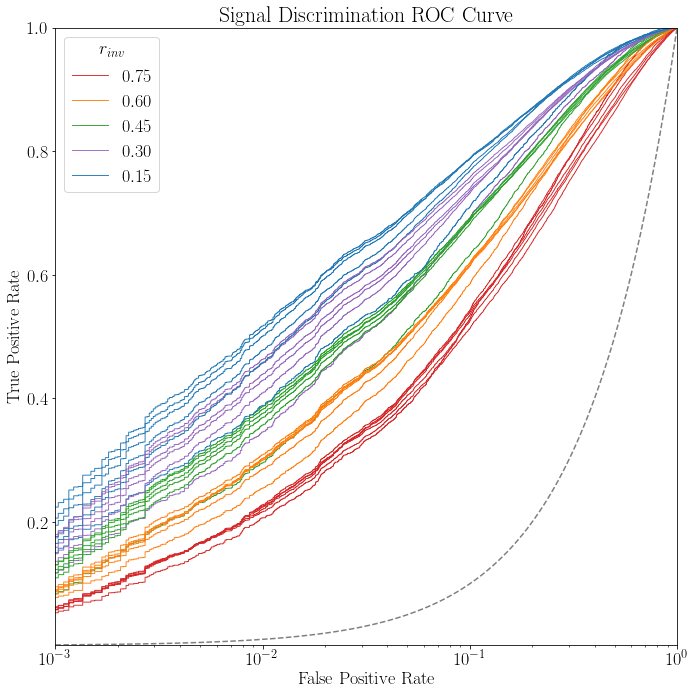

In [143]:
from matplotlib import lines as mplines
# errs = e.roc(figsize=10, yscale='log', xscale='log', figname='SVJ vs. QCD error', fontsize=20, show_plot=0)

prop_cycle = plt.rcParams['axes.prop_cycle']
all_colors = prop_cycle.by_key()['color']
all_lines = ['-', '--', '-.', ':', '-']
all_markers = ['x', 'o', 'v', 'D', 's', 'P']
# all_lines = ["s", "o", "d", "x", "1"]

masses, nus = map(set, np.asarray([[err.split('_')[1], '{:.2f}'.format(int(err.split('_')[2])/100.)] for err in errors.keys() if len(err.split('_')) >= 3]).T)
colors = {nu: all_colors[i] for i,nu in enumerate(nus)}
lines = {nu: '-' for i,nu in enumerate(nus)}
markers = {mass: all_markers[i] for i,mass in enumerate(masses)}

plt.figure(figsize=(10,10))
aucplot = aucs_.copy()

dots = np.logspace(-3, -2, len(aucplot))
# index = np.argsort([(k, v['mae']['auc']) for k,v in aucplot.items()],axis=0)[:,1]
index = np.argsort([(k, v['mae']['roc'][1][np.argmin(abs(v['mae']['roc'][0] - 2*1e-3))]) for k,v in aucplot.items()], axis=0)[:,1]
i = 0 

used_labels = set()
used_styles = OrderedDict()
for a in aucplot:
    for typ in aucplot[a]:
        mass,nu = a.split('_')[1:]
        nu = '{:.2f}'.format(int(nu)/100.)
        roc = aucplot[a][typ]['roc']
        auc = aucplot[a][typ]['auc']
        
        lab = r'${}$'.format(nu)
        if lab in used_labels:
            lab = None
        used_labels.add(lab)
        
        
#         nex = dots[index[i]]
        idxs = [np.argmin(abs(roc[0] - x)) for x in np.logspace(-3, 0, 10)]
        nex = 2e-3
#         xplt = np.argmin(abs(roc[0] - nex))
        i += 1 
        
        plt.plot(roc[0], roc[1], linestyle=lines[nu], c=colors[nu], label=lab, linewidth=0.9) 
        used_styles[(nu, mass)] = plt.plot(roc[0][idxs], roc[1][idxs], marker=None,#markers[mass],
                                           markeredgecolor=colors[nu], markerfacecolor='None',
                                           markersize=6, linestyle='None'
                                          )
        
    #, label=r'${}$, Nu={}'.format(mass, nu))
plt.plot(np.arange(0,1.001,0.001), np.arange(0,1.001,0.001), linestyle='--', c='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal Discrimination ROC Curve')
# plt.yscale('log')#
plt.xscale('log')
plt.legend(title=r'$r_{inv}$')
plt.ylim(1e-3, 1)
plt.xlim(1e-3, 1)

plt.show()

In [166]:
aucs

name,hlf_eflow3_10_v10,hlf_eflow3_10_v11,hlf_eflow3_10_v12,hlf_eflow3_10_v9,hlf_eflow3_4_v3,hlf_eflow3_5_v5,hlf_eflow3_5_v6,hlf_eflow3_5_v7,hlf_eflow3_5_v8,hlf_eflow3_5_v9,...,hlf_eflow3_8_v44,hlf_eflow3_8_v45,hlf_eflow3_8_v46,hlf_eflow3_9_v10,hlf_eflow3_9_v11,hlf_eflow3_9_v5,hlf_eflow3_9_v6,hlf_eflow3_9_v7,hlf_eflow3_9_v8,hlf_eflow3_9_v9
mass_nu_ratio,,,,,,,,,,,,,,,,,,,,,
"(1500.0, 0.15)",0.850593,0.863078,0.849331,0.875296,0.833696,0.861697,0.853388,0.843840,0.858118,0.847433,...,0.870950,0.854483,0.832470,0.877707,0.878600,0.874668,0.893249,0.858703,0.868799,0.883727
"(1500.0, 0.3)",0.837540,0.851636,0.833455,0.863711,0.821548,0.849748,0.840613,0.828680,0.844063,0.834483,...,0.857442,0.843858,0.818477,0.865811,0.865803,0.861208,0.880702,0.844504,0.856469,0.871815
"(1500.0, 0.45)",0.810757,0.829831,0.812858,0.843554,0.793833,0.828267,0.817108,0.809040,0.823790,0.811280,...,0.840513,0.819057,0.791785,0.846979,0.846941,0.841918,0.863348,0.824387,0.834846,0.851293
"(1500.0, 0.6)",0.791382,0.812176,0.794348,0.828215,0.774653,0.814089,0.803931,0.793264,0.809795,0.787611,...,0.821522,0.795778,0.771726,0.830050,0.829341,0.824336,0.846217,0.809634,0.817838,0.833410
"(1500.0, 0.75)",0.762349,0.789072,0.771876,0.809930,0.748562,0.795547,0.781475,0.772857,0.788344,0.760576,...,0.799796,0.769648,0.740444,0.810511,0.810477,0.803867,0.827367,0.785370,0.795573,0.811707
"(2000.0, 0.15)",0.872354,0.884535,0.868153,0.885270,0.862339,0.865511,0.869953,0.853245,0.871201,0.871998,...,0.875322,0.878606,0.843660,0.891121,0.891995,0.887739,0.901160,0.874342,0.880463,0.897123
"(2000.0, 0.3)",0.855074,0.869074,0.852412,0.872492,0.843960,0.852489,0.855463,0.838854,0.858240,0.851223,...,0.862226,0.861326,0.828473,0.878322,0.878353,0.874993,0.890887,0.860020,0.867238,0.884906
"(2000.0, 0.45)",0.833616,0.851224,0.831187,0.855471,0.821423,0.836093,0.837599,0.820751,0.842513,0.827782,...,0.843108,0.838225,0.804194,0.860009,0.860433,0.855548,0.872505,0.842346,0.848532,0.866386
"(2000.0, 0.6)",0.801845,0.823878,0.801002,0.830578,0.791142,0.813525,0.812111,0.793883,0.817033,0.796691,...,0.819888,0.807342,0.774444,0.833958,0.833640,0.828152,0.848970,0.815112,0.821476,0.839824


In [172]:
np.isclose(res,best)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]], dtype=bool)

In [164]:
res2 = aucs['hlf_eflow3_8_v36']
aucs


mass_nu_ratio
(1500.0, 0.15)    0.900009
(1500.0, 0.3)     0.889484
(1500.0, 0.45)    0.872205
(1500.0, 0.6)     0.851334
(1500.0, 0.75)    0.829660
(2000.0, 0.15)    0.918012
(2000.0, 0.3)     0.905022
(2000.0, 0.45)    0.884582
(2000.0, 0.6)     0.858131
(2000.0, 0.75)    0.828030
(2500.0, 0.15)    0.919271
(2500.0, 0.3)     0.904256
(2500.0, 0.45)    0.884583
(2500.0, 0.6)     0.856410
(2500.0, 0.75)    0.819615
(3000.0, 0.15)    0.921675
(3000.0, 0.3)     0.904776
(3000.0, 0.45)    0.884526
(3000.0, 0.6)     0.853104
(3000.0, 0.75)    0.814163
(3500.0, 0.15)    0.922429
(3500.0, 0.3)     0.908776
(3500.0, 0.45)    0.882671
(3500.0, 0.6)     0.849920
(3500.0, 0.75)    0.809376
(4000.0, 0.15)    0.920697
(4000.0, 0.3)     0.909620
(4000.0, 0.45)    0.881375
(4000.0, 0.6)     0.849791
(4000.0, 0.75)    0.802760
Name: hlf_eflow3_8_v36, dtype: float64

In [169]:
res = pd.DataFrame([[k, v.values()[0]['auc']] for k, v in aucplot.items()], columns=['name', 'auc'])
res['mass'] = res.name.apply(lambda x: int(x.split('_')[1].rstrip('GeV')))
res['nu'] = res.name.apply(lambda x: float(x.split('_')[2])/100.)
res = res.pivot('mass', 'nu', 'auc')

In [ ]:
df = pd.DataFrame({k: v['mae'] for k,v in aucplot.items()}).T['auc'].to_frame()
df['nu'] = [int(x.split('_')[2])/100. for x in df.index.values]
df['mass'] = [int(x.split('_')[1].rstrip('GeV')) for x in df.index.values]
df = df.pivot('mass', 'nu', 'auc')

In [ ]:
qcd_mae = (agetter.get_test_dataset(dholder).df - recon['qcd pred'].df).abs()
signal_mae = (signal.df - signal_recon.df).abs()

In [ ]:
utils.data_table(qcd_mae, name='qcd').plot(utils.data_table(signal_mae, name='signal'), normed=1, bins=100, xscale='log')